In [8]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

print("Imported all necessary libraries!")

Imported all necessary libraries!


In [10]:
# โหลดข้อมูล
df = pd.read_csv("thai_plastic_bottle_waste_monthly_dataset_with_missing.csv")

# แยก Date เป็น Year และ Month
df['Year'] = df['Date'].apply(lambda x: int(x.split('-')[0]))
df['Month'] = df['Date'].apply(lambda x: int(x.split('-')[1]))

# Feature Engineering
df['Waste_per_Population'] = df['Plastic Bottle Waste Generated (Million Bottles)'] / df['Population (Million)']
df['Waste_Policy_Interaction'] = df['Plastic Bottle Waste Generated (Million Bottles)'] * df['Recycling Policy Level (0-3)']
df['Trend_Policy_Interaction'] = df['Recycling Trend (0-100)'] * df['Recycling Policy Level (0-3)']
df['Year_Trend'] = df['Year'] * df['Recycling Trend (0-100)']

# เลือก Features และ Target
features = ['Year', 'Month', 'Plastic Bottle Waste Generated (Million Bottles)', 
            'Recycling Percentage (%)', 'Recycling Trend (0-100)', 
            'Population (Million)', 'Recycling Policy Level (0-3)', 
            'Waste_per_Population', 'Waste_Policy_Interaction', 'Trend_Policy_Interaction', 'Year_Trend']
X = df[features]
y = df['Recycling Rate (Million Bottles)']

# จัดการ Missing Values ด้วย KNNImputer
imputer = KNNImputer(n_neighbors=5, weights='distance')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=features)
y_imputed = pd.Series(imputer.fit_transform(y.values.reshape(-1, 1)).flatten(), name=y.name)

# ลบแถวที่มี NaN หลัง imputation
mask = X_imputed.notna().all(axis=1) & y_imputed.notna()
X_imputed = X_imputed[mask]
y_imputed = y_imputed[mask]

# ตรวจสอบ outliers และตัดทิ้ง
def remove_outliers(df_col):
    z_scores = (df_col - df_col.mean()) / df_col.std()
    return df_col[abs(z_scores) < 3]

for col in X_imputed.columns:
    X_imputed[col] = remove_outliers(X_imputed[col])
y_imputed = remove_outliers(y_imputed)

mask = X_imputed.notna().all(axis=1) & y_imputed.notna()
X_imputed = X_imputed[mask]
y_imputed = y_imputed[mask]

# แบ่งข้อมูล Train/Test
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_imputed, test_size=0.2, random_state=42)

# ปรับสเกลข้อมูล
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# บันทึก Imputer และ Scaler
with open('imputer_new.pkl', 'wb') as f:
    pickle.dump(imputer, f)
with open('scaler_new.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Data preprocessing completed!")
print("Test set shape:", X_test_scaled.shape)
print("Features used:", features)

Data preprocessing completed!
Test set shape: (59, 11)
Features used: ['Year', 'Month', 'Plastic Bottle Waste Generated (Million Bottles)', 'Recycling Percentage (%)', 'Recycling Trend (0-100)', 'Population (Million)', 'Recycling Policy Level (0-3)', 'Waste_per_Population', 'Waste_Policy_Interaction', 'Trend_Policy_Interaction', 'Year_Trend']


In [12]:
# SVR
svr = SVR(kernel='rbf')
param_grid_svr = {'C': [50, 100, 200], 'epsilon': [0.01, 0.1], 'gamma': ['scale', 0.01, 0.1]}
grid_search_svr = GridSearchCV(svr, param_grid_svr, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_svr.fit(X_train_scaled, y_train)
best_svr = grid_search_svr.best_estimator_
y_pred_svr = best_svr.predict(X_test_scaled)
svr_mse = mean_squared_error(y_test, y_pred_svr)
svr_r2 = r2_score(y_test, y_pred_svr)
print("SVR - MSE:", svr_mse, "R²:", svr_r2)
with open('svr_model_new.pkl', 'wb') as f:
    pickle.dump(best_svr, f)

# Decision Tree
dt = DecisionTreeRegressor(random_state=42)
param_grid_dt = {'max_depth': [5, 7, 10], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_dt.fit(X_train_scaled, y_train)
best_dt = grid_search_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test_scaled)
dt_mse = mean_squared_error(y_test, y_pred_dt)
dt_r2 = r2_score(y_test, y_pred_dt)
print("Decision Tree - MSE:", dt_mse, "R²:", dt_r2)
with open('dt_model_new.pkl', 'wb') as f:
    pickle.dump(best_dt, f)

# KNN
knn = KNeighborsRegressor()
param_grid_knn = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance'], 'p': [1, 2]}
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_knn.fit(X_train_scaled, y_train)
best_knn = grid_search_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test_scaled)
knn_mse = mean_squared_error(y_test, y_pred_knn)
knn_r2 = r2_score(y_test, y_pred_knn)
print("KNN - MSE:", knn_mse, "R²:", knn_r2)
with open('knn_model_new.pkl', 'wb') as f:
    pickle.dump(best_knn, f)

# Random Forest
rf = RandomForestRegressor(random_state=42)
param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [10, 15, 20], 'min_samples_split': [2, 5]}
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_rf.fit(X_train_scaled, y_train)
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test_scaled)
rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)
print("Random Forest - MSE:", rf_mse, "R²:", rf_r2)
with open('rf_model_new.pkl', 'wb') as f:
    pickle.dump(best_rf, f)

# SVM Linear
svm_reg = SVR(kernel='linear')
param_grid_svm = {'C': [10, 50, 100], 'epsilon': [0.01, 0.1, 0.5]}
grid_search_svm = GridSearchCV(svm_reg, param_grid_svm, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_svm.fit(X_train_scaled, y_train)
best_svm = grid_search_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test_scaled)
svm_mse = mean_squared_error(y_test, y_pred_svm)
svm_r2 = r2_score(y_test, y_pred_svm)
print("SVM Linear - MSE:", svm_mse, "R²:", svm_r2)
with open('svm_linear_model_new.pkl', 'wb') as f:
    pickle.dump(best_svm, f)

print("All models trained and saved with 11 features!")

SVR - MSE: 23.26363579302995 R²: 0.8231129982218075
Decision Tree - MSE: 48.607880520925626 R²: 0.6304059122729548
KNN - MSE: 33.94780406832288 R²: 0.741875030540226
Random Forest - MSE: 36.363982584582054 R²: 0.7235034149722923
SVM Linear - MSE: 26.17207745359965 R²: 0.800998418636655
All models trained and saved with 11 features!


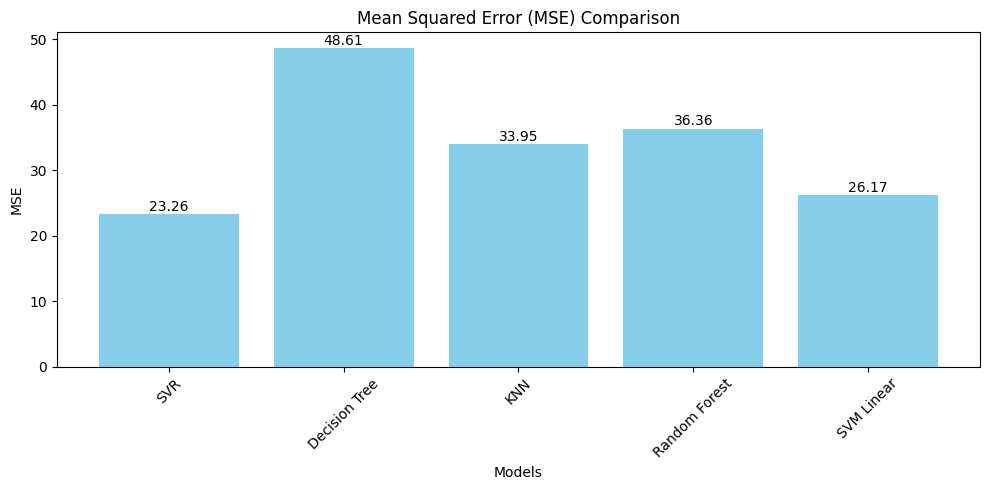

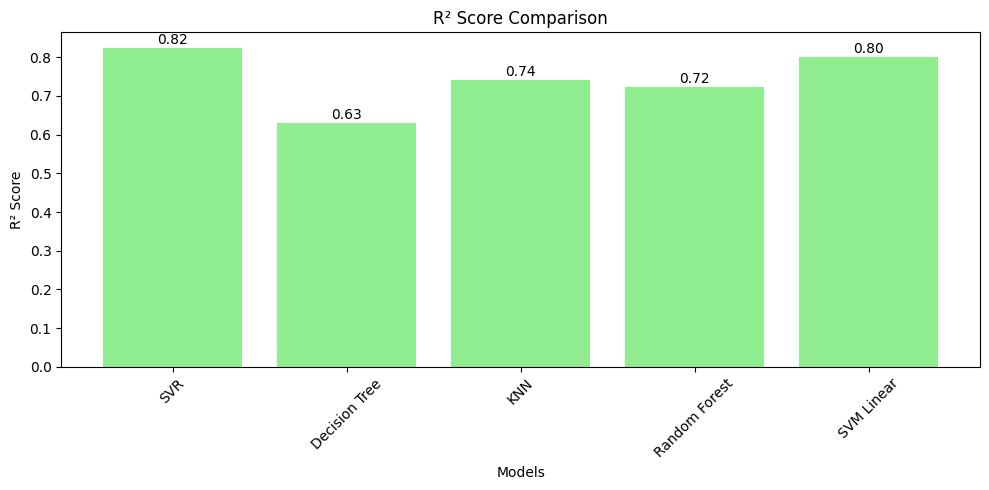


Model Comparison:
           Model        MSE        R²
0            SVR  23.263636  0.823113
4     SVM Linear  26.172077  0.800998
2            KNN  33.947804  0.741875
3  Random Forest  36.363983  0.723503
1  Decision Tree  48.607881  0.630406


In [13]:
# รวบรวมผลลัพธ์
models = ['SVR', 'Decision Tree', 'KNN', 'Random Forest', 'SVM Linear']
mse_scores = [svr_mse, dt_mse, knn_mse, rf_mse, svm_mse]
r2_scores = [svr_r2, dt_r2, knn_r2, rf_r2, svm_r2]

# พลอตกราฟ MSE
plt.figure(figsize=(10, 5))
plt.bar(models, mse_scores, color='skyblue')
plt.title('Mean Squared Error (MSE) Comparison')
plt.xlabel('Models')
plt.ylabel('MSE')
plt.xticks(rotation=45)
for i, v in enumerate(mse_scores):
    plt.text(i, v + 0.5, f'{v:.2f}', ha='center')
plt.tight_layout()
plt.show()

# พลอตกราฟ R²
plt.figure(figsize=(10, 5))
plt.bar(models, r2_scores, color='lightgreen')
plt.title('R² Score Comparison')
plt.xlabel('Models')
plt.ylabel('R² Score')
plt.xticks(rotation=45)
for i, v in enumerate(r2_scores):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center')
plt.tight_layout()
plt.show()

# สรุปผลในตาราง
results = pd.DataFrame({
    'Model': models,
    'MSE': mse_scores,
    'R²': r2_scores
})
print("\nModel Comparison:")
print(results.sort_values(by='MSE'))

In [2]:
# รวบรวมผลลัพธ์
models = ['SVR', 'Decision Tree', 'KNN', 'Random Forest', 'SVM Linear']
mse_scores = [svr_mse, dt_mse, knn_mse, rf_mse, svm_mse]
r2_scores = [svr_r2, dt_r2, knn_r2, rf_r2, svm_r2]

# พลอตกราฟ MSE แบบเชิงเส้น
plt.figure(figsize=(10, 5))
plt.plot(models, mse_scores, marker='o', color='blue', linestyle='-', label='MSE')
plt.title('Mean Squared Error (MSE) Comparison')
plt.xlabel('Models')
plt.ylabel('MSE')
plt.xticks(rotation=45)
for i, v in enumerate(mse_scores):
    plt.text(i, v + 0.5, f'{v:.2f}', ha='center')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# พลอตกราฟ R² แบบเชิงเส้น
plt.figure(figsize=(10, 5))
plt.plot(models, r2_scores, marker='o', color='green', linestyle='-', label='R²')
plt.title('R² Score Comparison')
plt.xlabel('Models')
plt.ylabel('R² Score')
plt.xticks(rotation=45)
for i, v in enumerate(r2_scores):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# สรุปผลในตาราง
results = pd.DataFrame({
    'Model': models,
    'MSE': mse_scores,
    'R²': r2_scores
})
print("\nModel Comparison:")
print(results.sort_values(by='MSE'))

NameError: name 'svr_mse' is not defined

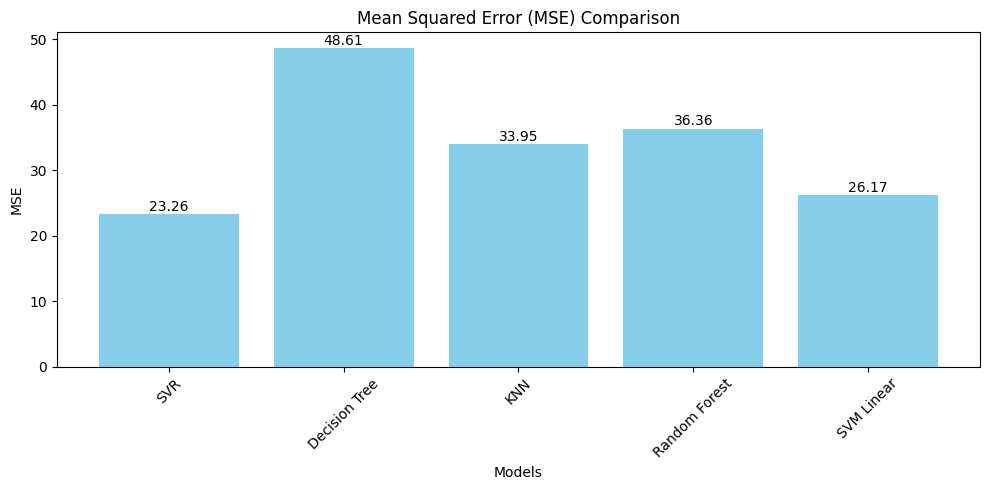

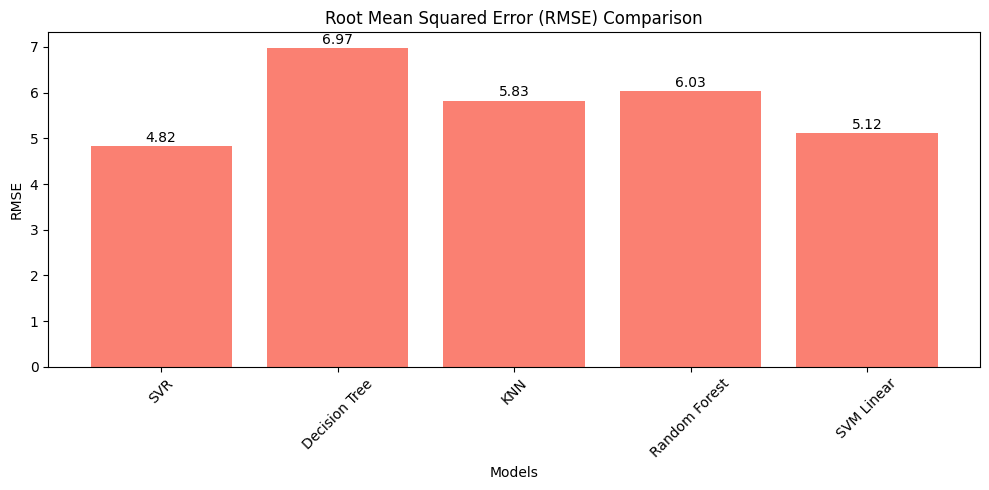

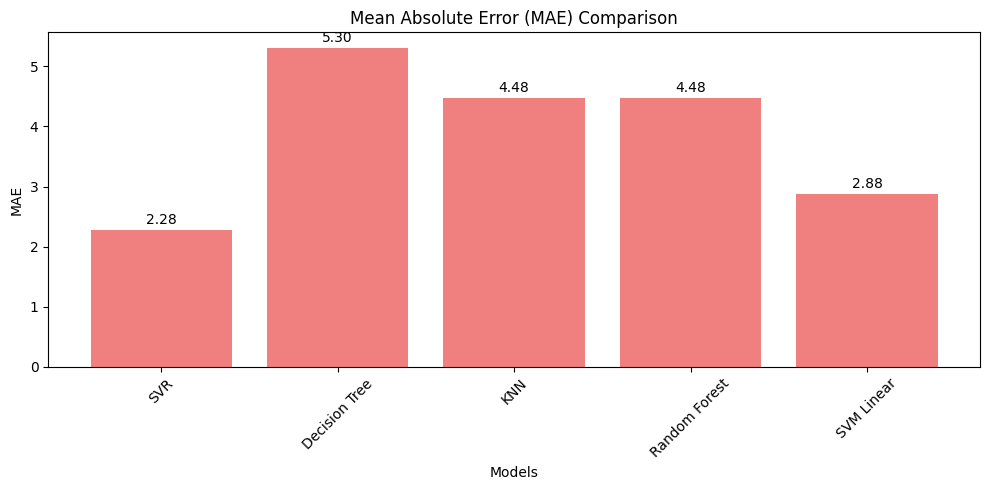

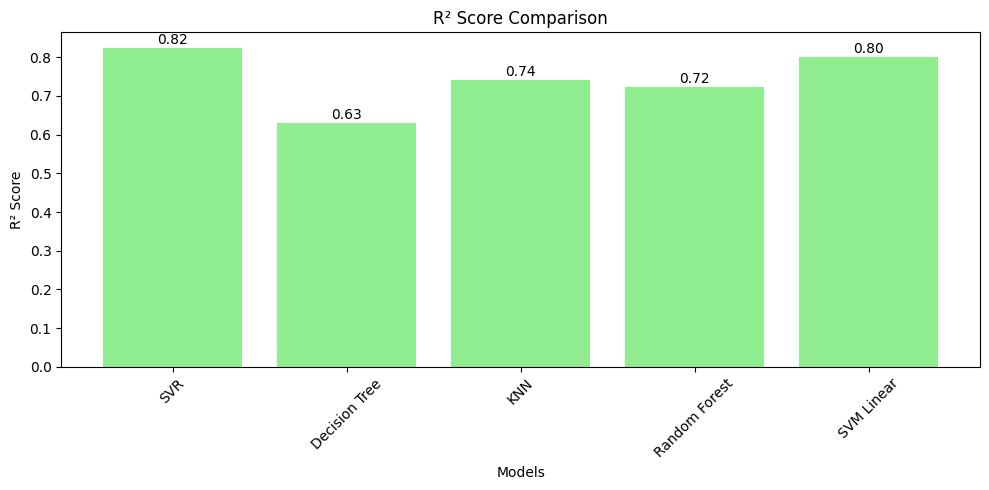

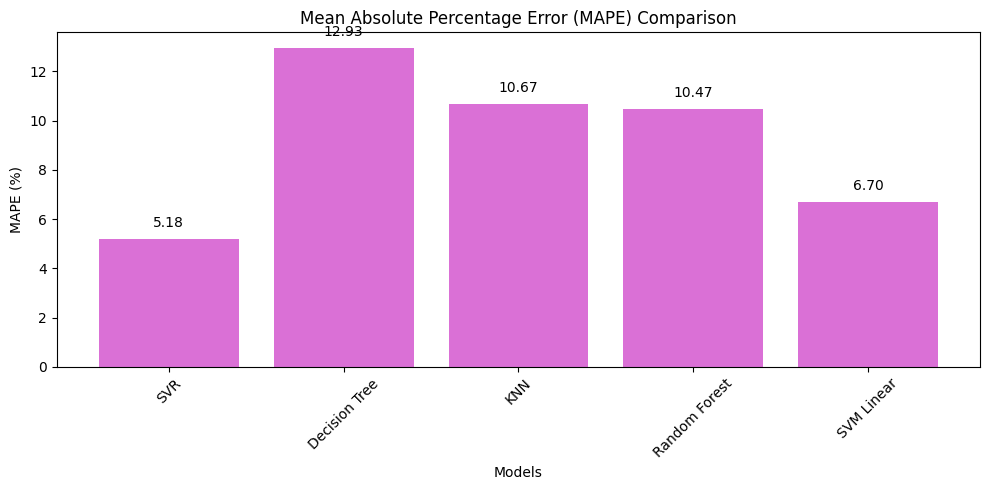

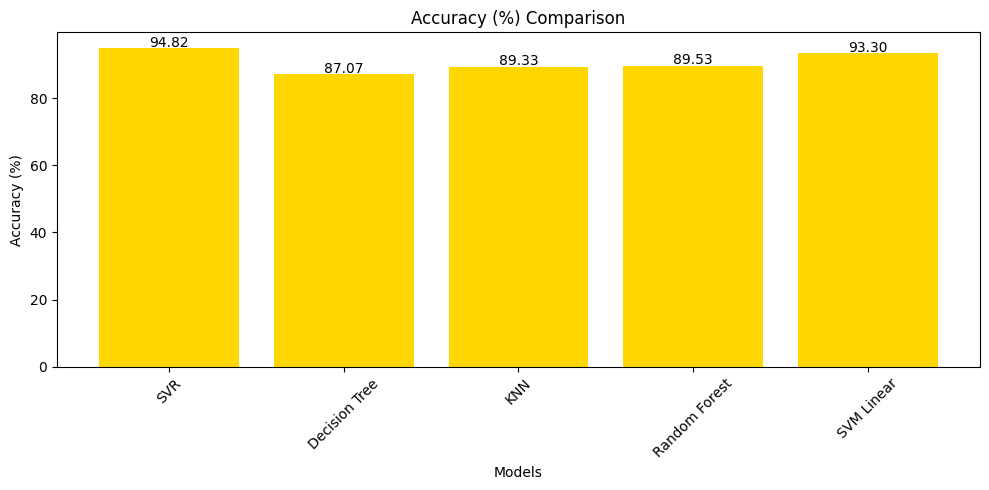


Model Comparison:
           Model        MSE      RMSE       MAE        R²   MAPE (%)  \
0            SVR  23.263636  4.823239  2.276667  0.823113   5.176816   
4     SVM Linear  26.172077  5.115865  2.877203  0.800998   6.699167   
2            KNN  33.947804  5.826474  4.480511  0.741875  10.668744   
3  Random Forest  36.363983  6.030256  4.476508  0.723503  10.470819   
1  Decision Tree  48.607881  6.971935  5.300284  0.630406  12.934504   

   Accuracy (%)  
0     94.823184  
4     93.300833  
2     89.331256  
3     89.529181  
1     87.065496  

ผลลัพธ์ถูกบันทึกเป็นไฟล์ 'model_performance.csv' เรียบร้อยแล้ว!


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# โหลดข้อมูล
df = pd.read_csv("thai_plastic_bottle_waste_monthly_dataset_with_missing.csv")

# แยก Date เป็น Year และ Month
df['Year'] = df['Date'].apply(lambda x: int(x.split('-')[0]))
df['Month'] = df['Date'].apply(lambda x: int(x.split('-')[1]))

# Feature Engineering
df['Waste_per_Population'] = df['Plastic Bottle Waste Generated (Million Bottles)'] / df['Population (Million)']
df['Waste_Policy_Interaction'] = df['Plastic Bottle Waste Generated (Million Bottles)'] * df['Recycling Policy Level (0-3)']
df['Trend_Policy_Interaction'] = df['Recycling Trend (0-100)'] * df['Recycling Policy Level (0-3)']
df['Year_Trend'] = df['Year'] * df['Recycling Trend (0-100)']

# เลือก Features และ Target
features = ['Year', 'Month', 'Plastic Bottle Waste Generated (Million Bottles)', 
            'Recycling Percentage (%)', 'Recycling Trend (0-100)', 
            'Population (Million)', 'Recycling Policy Level (0-3)', 
            'Waste_per_Population', 'Waste_Policy_Interaction', 'Trend_Policy_Interaction', 'Year_Trend']
X = df[features]
y = df['Recycling Rate (Million Bottles)']

# จัดการ Missing Values ด้วย KNNImputer
imputer = KNNImputer(n_neighbors=5, weights='distance')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=features)
y_imputed = pd.Series(imputer.fit_transform(y.values.reshape(-1, 1)).flatten(), name=y.name)

# ลบแถวที่มี NaN หลัง imputation
mask = X_imputed.notna().all(axis=1) & y_imputed.notna()
X_imputed = X_imputed[mask]
y_imputed = y_imputed[mask]

# ตรวจสอบ outliers และตัดทิ้ง
def remove_outliers(df_col):
    z_scores = (df_col - df_col.mean()) / df_col.std()
    return df_col[abs(z_scores) < 3]

for col in X_imputed.columns:
    X_imputed[col] = remove_outliers(X_imputed[col])
y_imputed = remove_outliers(y_imputed)

mask = X_imputed.notna().all(axis=1) & y_imputed.notna()
X_imputed = X_imputed[mask]
y_imputed = y_imputed[mask]

# แบ่งข้อมูล Train/Test
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_imputed, test_size=0.2, random_state=42)

# ปรับสเกลข้อมูล
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ฝึกโมเดล SVR
svr = SVR(kernel='rbf')
param_grid_svr = {'C': [50, 100, 200], 'epsilon': [0.01, 0.1], 'gamma': ['scale', 0.01, 0.1]}
grid_search_svr = GridSearchCV(svr, param_grid_svr, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_svr.fit(X_train_scaled, y_train)
best_svr = grid_search_svr.best_estimator_
y_pred_svr = best_svr.predict(X_test_scaled)
svr_mse = mean_squared_error(y_test, y_pred_svr)
svr_r2 = r2_score(y_test, y_pred_svr)

# ฝึกโมเดล Decision Tree
dt = DecisionTreeRegressor(random_state=42)
param_grid_dt = {'max_depth': [5, 7, 10], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_dt.fit(X_train_scaled, y_train)
best_dt = grid_search_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test_scaled)
dt_mse = mean_squared_error(y_test, y_pred_dt)
dt_r2 = r2_score(y_test, y_pred_dt)

# ฝึกโมเดล KNN
knn = KNeighborsRegressor()
param_grid_knn = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance'], 'p': [1, 2]}
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_knn.fit(X_train_scaled, y_train)
best_knn = grid_search_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test_scaled)
knn_mse = mean_squared_error(y_test, y_pred_knn)
knn_r2 = r2_score(y_test, y_pred_knn)

# ฝึกโมเดล Random Forest
rf = RandomForestRegressor(random_state=42)
param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [10, 15, 20], 'min_samples_split': [2, 5]}
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_rf.fit(X_train_scaled, y_train)
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test_scaled)
rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)

# ฝึกโมเดล SVM Linear
svm_reg = SVR(kernel='linear')
param_grid_svm = {'C': [10, 50, 100], 'epsilon': [0.01, 0.1, 0.5]}
grid_search_svm = GridSearchCV(svm_reg, param_grid_svm, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_svm.fit(X_train_scaled, y_train)
best_svm = grid_search_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test_scaled)
svm_mse = mean_squared_error(y_test, y_pred_svm)
svm_r2 = r2_score(y_test, y_pred_svm)

# รวบรวมผลลัพธ์
models = ['SVR', 'Decision Tree', 'KNN', 'Random Forest', 'SVM Linear']
mse_scores = [svr_mse, dt_mse, knn_mse, rf_mse, svm_mse]
r2_scores = [svr_r2, dt_r2, knn_r2, rf_r2, svm_r2]
y_preds = [y_pred_svr, y_pred_dt, y_pred_knn, y_pred_rf, y_pred_svm]

# คำนวณ RMSE, MAE, MAPE และ Accuracy
rmse_scores = [np.sqrt(mse) for mse in mse_scores]
mae_scores = [mean_absolute_error(y_test, y_pred) for y_pred in y_preds]
mape_scores = [np.mean(np.abs((y_test - y_pred) / y_test)) * 100 for y_pred in y_preds]
accuracy_scores = [100 - mape for mape in mape_scores]

# พลอตกราฟ MSE
plt.figure(figsize=(10, 5))
plt.bar(models, mse_scores, color='skyblue')
plt.title('Mean Squared Error (MSE) Comparison')
plt.xlabel('Models')
plt.ylabel('MSE')
plt.xticks(rotation=45)
for i, v in enumerate(mse_scores):
    plt.text(i, v + 0.5, f'{v:.2f}', ha='center')
plt.tight_layout()
plt.show()

# พลอตกราฟ RMSE
plt.figure(figsize=(10, 5))
plt.bar(models, rmse_scores, color='salmon')
plt.title('Root Mean Squared Error (RMSE) Comparison')
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
for i, v in enumerate(rmse_scores):
    plt.text(i, v + 0.1, f'{v:.2f}', ha='center')
plt.tight_layout()
plt.show()

# พลอตกราฟ MAE
plt.figure(figsize=(10, 5))
plt.bar(models, mae_scores, color='lightcoral')
plt.title('Mean Absolute Error (MAE) Comparison')
plt.xlabel('Models')
plt.ylabel('MAE')
plt.xticks(rotation=45)
for i, v in enumerate(mae_scores):
    plt.text(i, v + 0.1, f'{v:.2f}', ha='center')
plt.tight_layout()
plt.show()

# พลอตกราฟ R²
plt.figure(figsize=(10, 5))
plt.bar(models, r2_scores, color='lightgreen')
plt.title('R² Score Comparison')
plt.xlabel('Models')
plt.ylabel('R² Score')
plt.xticks(rotation=45)
for i, v in enumerate(r2_scores):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center')
plt.tight_layout()
plt.show()

# พลอตกราฟ MAPE
plt.figure(figsize=(10, 5))
plt.bar(models, mape_scores, color='orchid')
plt.title('Mean Absolute Percentage Error (MAPE) Comparison')
plt.xlabel('Models')
plt.ylabel('MAPE (%)')
plt.xticks(rotation=45)
for i, v in enumerate(mape_scores):
    plt.text(i, v + 0.5, f'{v:.2f}', ha='center')
plt.tight_layout()
plt.show()

# พลอตกราฟ Accuracy
plt.figure(figsize=(10, 5))
plt.bar(models, accuracy_scores, color='gold')
plt.title('Accuracy (%) Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=45)
for i, v in enumerate(accuracy_scores):
    plt.text(i, v + 0.5, f'{v:.2f}', ha='center')
plt.tight_layout()
plt.show()

# สรุปผลในตาราง
results = pd.DataFrame({
    'Model': models,
    'MSE': mse_scores,
    'RMSE': rmse_scores,
    'MAE': mae_scores,
    'R²': r2_scores,
    'MAPE (%)': mape_scores,
    'Accuracy (%)': accuracy_scores
})
print("\nModel Comparison:")
print(results.sort_values(by='MSE'))

# บันทึกผลลัพธ์เป็นไฟล์ CSV
results.to_csv('model_performance.csv', index=False)
print("\nผลลัพธ์ถูกบันทึกเป็นไฟล์ 'model_performance.csv' เรียบร้อยแล้ว!")


โมเดลทั้งหมดถูกบันทึกเป็นไฟล์ .pkl เรียบร้อยแล้ว!


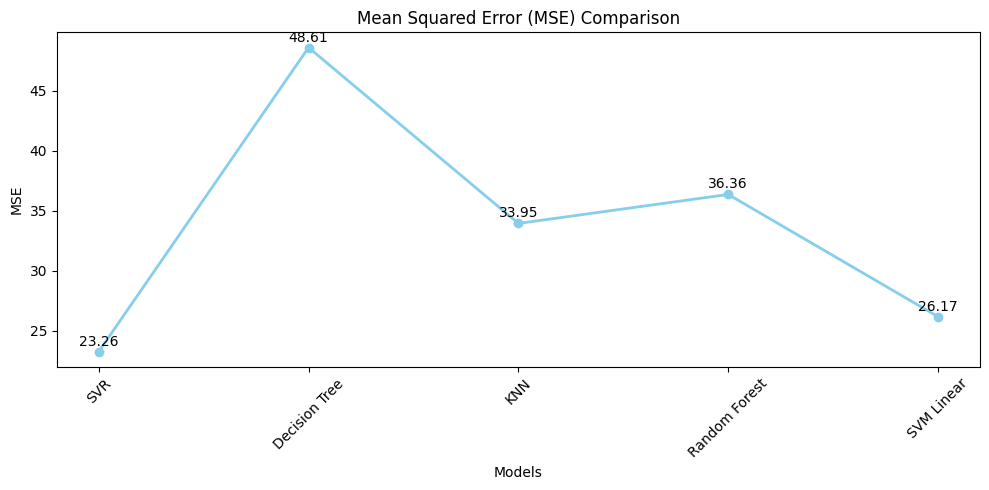

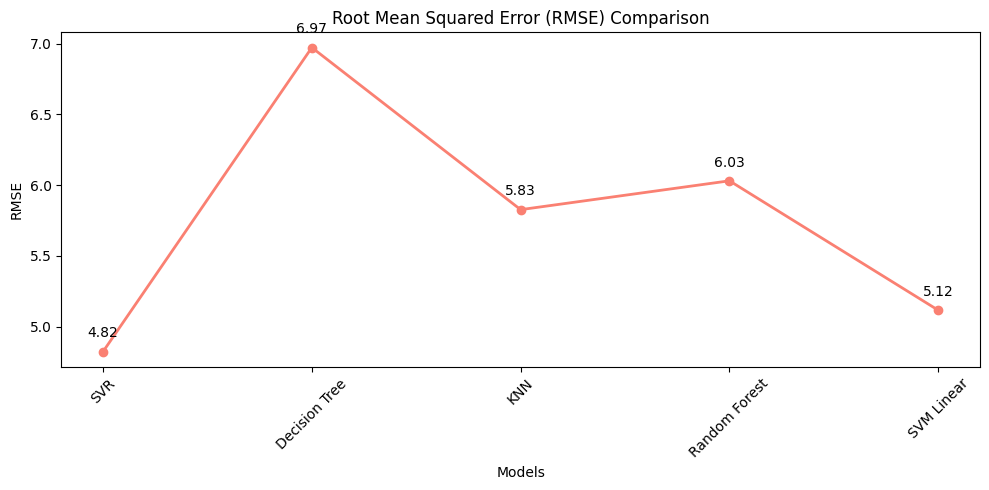

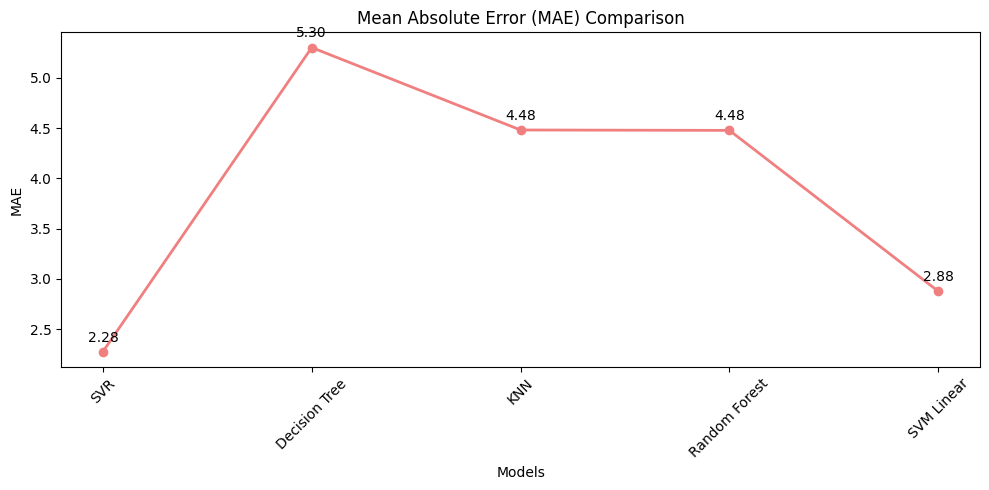

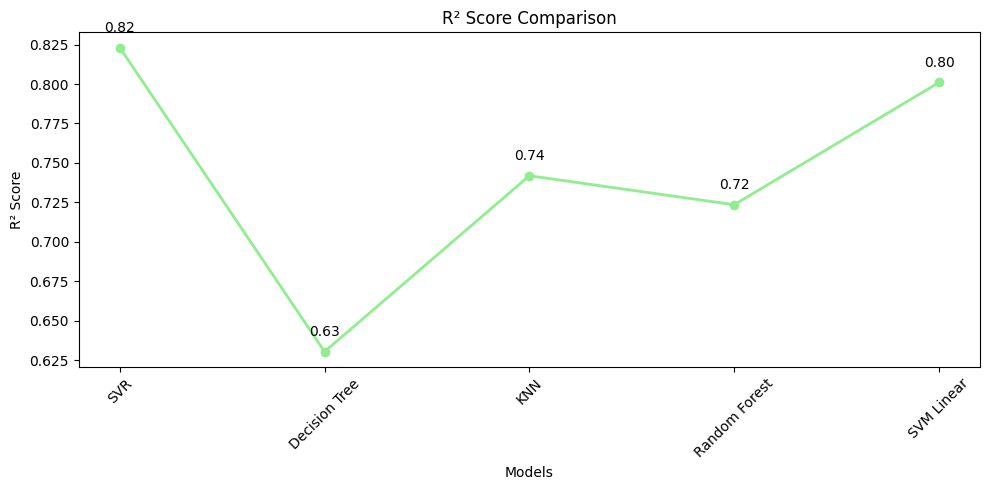

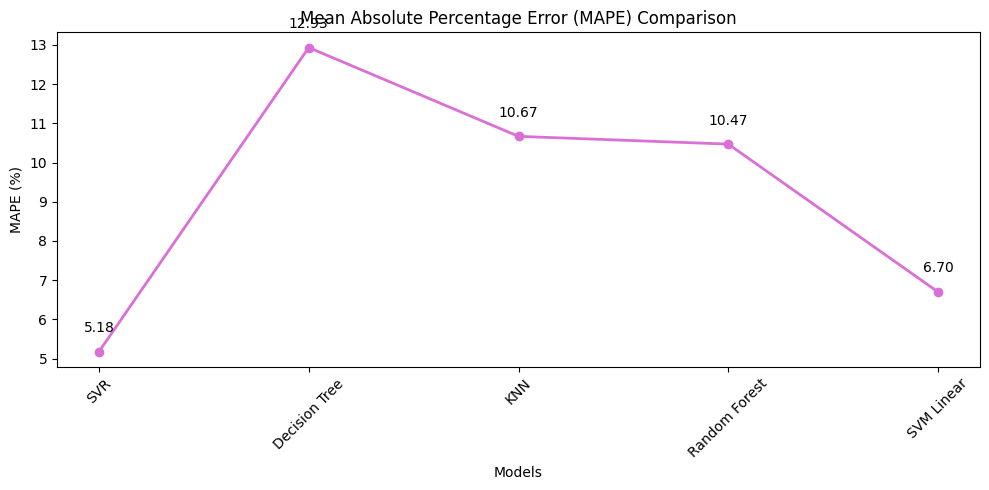

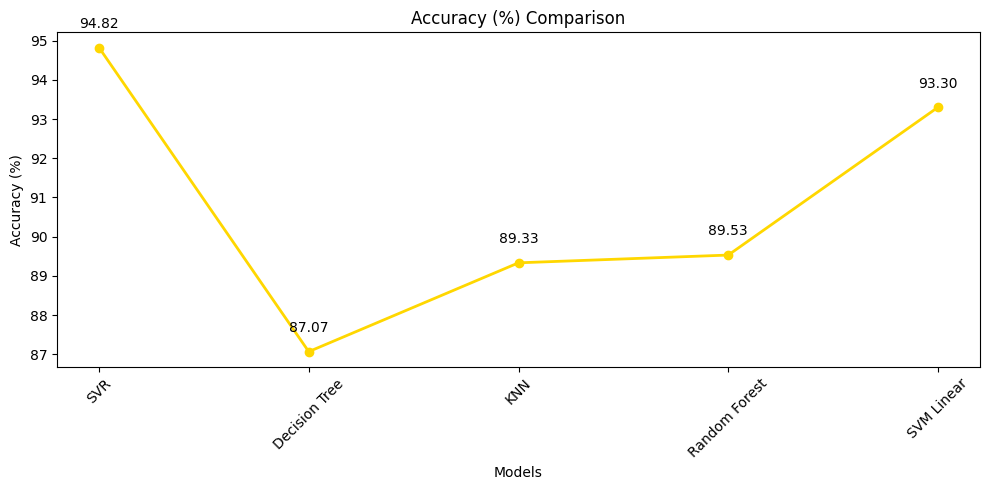


Model Comparison:
           Model        MSE      RMSE       MAE        R²   MAPE (%)  \
0            SVR  23.263636  4.823239  2.276667  0.823113   5.176816   
4     SVM Linear  26.172077  5.115865  2.877203  0.800998   6.699167   
2            KNN  33.947804  5.826474  4.480511  0.741875  10.668744   
3  Random Forest  36.363983  6.030256  4.476508  0.723503  10.470819   
1  Decision Tree  48.607881  6.971935  5.300284  0.630406  12.934504   

   Accuracy (%)  
0     94.823184  
4     93.300833  
2     89.331256  
3     89.529181  
1     87.065496  

ผลลัพธ์ถูกบันทึกเป็นไฟล์ 'model_performance.csv' เรียบร้อยแล้ว!


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pickle

# โหลดข้อมูล
df = pd.read_csv("thai_plastic_bottle_waste_monthly_dataset_with_missing.csv")

# แยก Date เป็น Year และ Month
df['Year'] = df['Date'].apply(lambda x: int(x.split('-')[0]))
df['Month'] = df['Date'].apply(lambda x: int(x.split('-')[1]))

# Feature Engineering
df['Waste_per_Population'] = df['Plastic Bottle Waste Generated (Million Bottles)'] / df['Population (Million)']
df['Waste_Policy_Interaction'] = df['Plastic Bottle Waste Generated (Million Bottles)'] * df['Recycling Policy Level (0-3)']
df['Trend_Policy_Interaction'] = df['Recycling Trend (0-100)'] * df['Recycling Policy Level (0-3)']
df['Year_Trend'] = df['Year'] * df['Recycling Trend (0-100)']

# เลือก Features และ Target
features = ['Year', 'Month', 'Plastic Bottle Waste Generated (Million Bottles)', 
            'Recycling Percentage (%)', 'Recycling Trend (0-100)', 
            'Population (Million)', 'Recycling Policy Level (0-3)', 
            'Waste_per_Population', 'Waste_Policy_Interaction', 'Trend_Policy_Interaction', 'Year_Trend']
X = df[features]
y = df['Recycling Rate (Million Bottles)']

# จัดการ Missing Values ด้วย KNNImputer
imputer = KNNImputer(n_neighbors=5, weights='distance')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=features)
y_imputed = pd.Series(imputer.fit_transform(y.values.reshape(-1, 1)).flatten(), name=y.name)

# ลบแถวที่มี NaN หลัง imputation
mask = X_imputed.notna().all(axis=1) & y_imputed.notna()
X_imputed = X_imputed[mask]
y_imputed = y_imputed[mask]

# ตรวจสอบ outliers และตัดทิ้ง
def remove_outliers(df_col):
    z_scores = (df_col - df_col.mean()) / df_col.std()
    return df_col[abs(z_scores) < 3]

for col in X_imputed.columns:
    X_imputed[col] = remove_outliers(X_imputed[col])
y_imputed = remove_outliers(y_imputed)

mask = X_imputed.notna().all(axis=1) & y_imputed.notna()
X_imputed = X_imputed[mask]
y_imputed = y_imputed[mask]

# แบ่งข้อมูล Train/Test
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_imputed, test_size=0.2, random_state=42)

# ปรับสเกลข้อมูล
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ฝึกโมเดล SVR
svr = SVR(kernel='rbf')
param_grid_svr = {'C': [50, 100, 200], 'epsilon': [0.01, 0.1], 'gamma': ['scale', 0.01, 0.1]}
grid_search_svr = GridSearchCV(svr, param_grid_svr, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_svr.fit(X_train_scaled, y_train)
best_svr = grid_search_svr.best_estimator_
y_pred_svr = best_svr.predict(X_test_scaled)
svr_mse = mean_squared_error(y_test, y_pred_svr)
svr_r2 = r2_score(y_test, y_pred_svr)

# ฝึกโมเดล Decision Tree
dt = DecisionTreeRegressor(random_state=42)
param_grid_dt = {'max_depth': [5, 7, 10], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_dt.fit(X_train_scaled, y_train)
best_dt = grid_search_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test_scaled)
dt_mse = mean_squared_error(y_test, y_pred_dt)
dt_r2 = r2_score(y_test, y_pred_dt)

# ฝึกโมเดล KNN
knn = KNeighborsRegressor()
param_grid_knn = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance'], 'p': [1, 2]}
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_knn.fit(X_train_scaled, y_train)
best_knn = grid_search_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test_scaled)
knn_mse = mean_squared_error(y_test, y_pred_knn)
knn_r2 = r2_score(y_test, y_pred_knn)

# ฝึกโมเดล Random Forest
rf = RandomForestRegressor(random_state=42)
param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [10, 15, 20], 'min_samples_split': [2, 5]}
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_rf.fit(X_train_scaled, y_train)
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test_scaled)
rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)

# ฝึกโมเดล SVM Linear
svm_reg = SVR(kernel='linear')
param_grid_svm = {'C': [10, 50, 100], 'epsilon': [0.01, 0.1, 0.5]}
grid_search_svm = GridSearchCV(svm_reg, param_grid_svm, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_svm.fit(X_train_scaled, y_train)
best_svm = grid_search_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test_scaled)
svm_mse = mean_squared_error(y_test, y_pred_svm)
svm_r2 = r2_score(y_test, y_pred_svm)

# บันทึกโมเดลเป็นไฟล์ .pkl
with open('svr_model.pkl', 'wb') as f:
    pickle.dump(best_svr, f)
with open('dt_model.pkl', 'wb') as f:
    pickle.dump(best_dt, f)
with open('knn_model.pkl', 'wb') as f:
    pickle.dump(best_knn, f)
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(best_rf, f)
with open('svm_linear_model.pkl', 'wb') as f:
    pickle.dump(best_svm, f)
print("\nโมเดลทั้งหมดถูกบันทึกเป็นไฟล์ .pkl เรียบร้อยแล้ว!")

# รวบรวมผลลัพธ์
models = ['SVR', 'Decision Tree', 'KNN', 'Random Forest', 'SVM Linear']
mse_scores = [svr_mse, dt_mse, knn_mse, rf_mse, svm_mse]
r2_scores = [svr_r2, dt_r2, knn_r2, rf_r2, svm_r2]
y_preds = [y_pred_svr, y_pred_dt, y_pred_knn, y_pred_rf, y_pred_svm]

# คำนวณ RMSE, MAE, MAPE และ Accuracy
rmse_scores = [np.sqrt(mse) for mse in mse_scores]
mae_scores = [mean_absolute_error(y_test, y_pred) for y_pred in y_preds]
mape_scores = [np.mean(np.abs((y_test - y_pred) / y_test)) * 100 for y_pred in y_preds]
accuracy_scores = [100 - mape for mape in mape_scores]

# พลอตกราฟ MSE (เชิงเส้น)
plt.figure(figsize=(10, 5))
plt.plot(models, mse_scores, marker='o', color='skyblue', linestyle='-', linewidth=2)
plt.title('Mean Squared Error (MSE) Comparison')
plt.xlabel('Models')
plt.ylabel('MSE')
plt.xticks(rotation=45)
for i, v in enumerate(mse_scores):
    plt.text(i, v + 0.5, f'{v:.2f}', ha='center')
plt.tight_layout()
plt.show()

# พลอตกราฟ RMSE (เชิงเส้น)
plt.figure(figsize=(10, 5))
plt.plot(models, rmse_scores, marker='o', color='salmon', linestyle='-', linewidth=2)
plt.title('Root Mean Squared Error (RMSE) Comparison')
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
for i, v in enumerate(rmse_scores):
    plt.text(i, v + 0.1, f'{v:.2f}', ha='center')
plt.tight_layout()
plt.show()

# พลอตกราฟ MAE (เชิงเส้น)
plt.figure(figsize=(10, 5))
plt.plot(models, mae_scores, marker='o', color='lightcoral', linestyle='-', linewidth=2)
plt.title('Mean Absolute Error (MAE) Comparison')
plt.xlabel('Models')
plt.ylabel('MAE')
plt.xticks(rotation=45)
for i, v in enumerate(mae_scores):
    plt.text(i, v + 0.1, f'{v:.2f}', ha='center')
plt.tight_layout()
plt.show()

# พลอตกราฟ R² (เชิงเส้น)
plt.figure(figsize=(10, 5))
plt.plot(models, r2_scores, marker='o', color='lightgreen', linestyle='-', linewidth=2)
plt.title('R² Score Comparison')
plt.xlabel('Models')
plt.ylabel('R² Score')
plt.xticks(rotation=45)
for i, v in enumerate(r2_scores):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center')
plt.tight_layout()
plt.show()

# พลอตกราฟ MAPE (เชิงเส้น)
plt.figure(figsize=(10, 5))
plt.plot(models, mape_scores, marker='o', color='orchid', linestyle='-', linewidth=2)
plt.title('Mean Absolute Percentage Error (MAPE) Comparison')
plt.xlabel('Models')
plt.ylabel('MAPE (%)')
plt.xticks(rotation=45)
for i, v in enumerate(mape_scores):
    plt.text(i, v + 0.5, f'{v:.2f}', ha='center')
plt.tight_layout()
plt.show()

# พลอตกราฟ Accuracy (เชิงเส้น)
plt.figure(figsize=(10, 5))
plt.plot(models, accuracy_scores, marker='o', color='gold', linestyle='-', linewidth=2)
plt.title('Accuracy (%) Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=45)
for i, v in enumerate(accuracy_scores):
    plt.text(i, v + 0.5, f'{v:.2f}', ha='center')
plt.tight_layout()
plt.show()

# สรุปผลในตาราง
results = pd.DataFrame({
    'Model': models,
    'MSE': mse_scores,
    'RMSE': rmse_scores,
    'MAE': mae_scores,
    'R²': r2_scores,
    'MAPE (%)': mape_scores,
    'Accuracy (%)': accuracy_scores
})
print("\nModel Comparison:")
print(results.sort_values(by='MSE'))

# บันทึกผลลัพธ์เป็นไฟล์ CSV
results.to_csv('model_performance.csv', index=False)
print("\nผลลัพธ์ถูกบันทึกเป็นไฟล์ 'model_performance.csv' เรียบร้อยแล้ว!")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pickle

# โหลดข้อมูล
df = pd.read_csv("thai_plastic_bottle_waste_monthly_dataset_with_missing.csv")

# แยก Date เป็น Year และ Month
df['Year'] = df['Date'].apply(lambda x: int(x.split('-')[0]))
df['Month'] = df['Date'].apply(lambda x: int(x.split('-')[1]))

# Feature Engineering
df['Waste_per_Population'] = df['Plastic Bottle Waste Generated (Million Bottles)'] / df['Population (Million)']
df['Waste_Policy_Interaction'] = df['Plastic Bottle Waste Generated (Million Bottles)'] * df['Recycling Policy Level (0-3)']
df['Trend_Policy_Interaction'] = df['Recycling Trend (0-100)'] * df['Recycling Policy Level (0-3)']
df['Year_Trend'] = df['Year'] * df['Recycling Trend (0-100)']

# เลือก Features และ Target
features = ['Year', 'Month', 'Plastic Bottle Waste Generated (Million Bottles)', 
            'Recycling Percentage (%)', 'Recycling Trend (0-100)', 
            'Population (Million)', 'Recycling Policy Level (0-3)', 
            'Waste_per_Population', 'Waste_Policy_Interaction', 'Trend_Policy_Interaction', 'Year_Trend']
X = df[features]
y = df['Recycling Rate (Million Bottles)']

# จัดการ Missing Values ด้วย KNNImputer
imputer = KNNImputer(n_neighbors=5, weights='distance')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=features)
y_imputed = pd.Series(imputer.fit_transform(y.values.reshape(-1, 1)).flatten(), name=y.name)

# ลบแถวที่มี NaN หลัง imputation
mask = X_imputed.notna().all(axis=1) & y_imputed.notna()
X_imputed = X_imputed[mask]
y_imputed = y_imputed[mask]

# ตรวจสอบ outliers และตัดทิ้ง
def remove_outliers(df_col):
    z_scores = (df_col - df_col.mean()) / df_col.std()
    return df_col[abs(z_scores) < 3]

for col in X_imputed.columns:
    X_imputed[col] = remove_outliers(X_imputed[col])
y_imputed = remove_outliers(y_imputed)

mask = X_imputed.notna().all(axis=1) & y_imputed.notna()
X_imputed = X_imputed[mask]
y_imputed = y_imputed[mask]

# แบ่งข้อมูล Train/Test
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_imputed, test_size=0.2, random_state=42)

# ปรับสเกลข้อมูล
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("บันทึก scaler เป็น scaler.pkl เรียบร้อย!")
X_test_scaled = scaler.transform(X_test)

# ฝึกโมเดล SVR
svr = SVR(kernel='rbf')
param_grid_svr = {'C': [50, 100, 200], 'epsilon': [0.01, 0.1], 'gamma': ['scale', 0.01, 0.1]}
grid_search_svr = GridSearchCV(svr, param_grid_svr, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_svr.fit(X_train_scaled, y_train)
best_svr = grid_search_svr.best_estimator_
y_pred_svr = best_svr.predict(X_test_scaled)
svr_mse = mean_squared_error(y_test, y_pred_svr)
svr_r2 = r2_score(y_test, y_pred_svr)

# ฝึกโมเดล Decision Tree
dt = DecisionTreeRegressor(random_state=42)
param_grid_dt = {'max_depth': [5, 7, 10], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_dt.fit(X_train_scaled, y_train)
best_dt = grid_search_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test_scaled)
dt_mse = mean_squared_error(y_test, y_pred_dt)
dt_r2 = r2_score(y_test, y_pred_dt)

# ฝึกโมเดล KNN
knn = KNeighborsRegressor()
param_grid_knn = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance'], 'p': [1, 2]}
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_knn.fit(X_train_scaled, y_train)
best_knn = grid_search_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test_scaled)
knn_mse = mean_squared_error(y_test, y_pred_knn)
knn_r2 = r2_score(y_test, y_pred_knn)

# ฝึกโมเดล Random Forest
rf = RandomForestRegressor(random_state=42)
param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [10, 15, 20], 'min_samples_split': [2, 5]}
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_rf.fit(X_train_scaled, y_train)
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test_scaled)
rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)

# ฝึกโมเดล SVM Linear
svm_reg = SVR(kernel='linear')
param_grid_svm = {'C': [10, 50, 100], 'epsilon': [0.01, 0.1, 0.5]}
grid_search_svm = GridSearchCV(svm_reg, param_grid_svm, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_svm.fit(X_train_scaled, y_train)
best_svm = grid_search_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test_scaled)
svm_mse = mean_squared_error(y_test, y_pred_svm)
svm_r2 = r2_score(y_test, y_pred_svm)

# บันทึกโมเดลเป็นไฟล์ .pkl
with open('svr_model.pkl', 'wb') as f:
    pickle.dump(best_svr, f)
with open('dt_model.pkl', 'wb') as f:
    pickle.dump(best_dt, f)
with open('knn_model.pkl', 'wb') as f:
    pickle.dump(best_knn, f)
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(best_rf, f)
with open('svm_linear_model.pkl', 'wb') as f:
    pickle.dump(best_svm, f)
print("\nโมเดลทั้งหมดถูกบันทึกเป็นไฟล์ .pkl เรียบร้อยแล้ว!")

# รวบรวมผลลัพธ์
models = ['SVR', 'Decision Tree', 'KNN', 'Random Forest', 'SVM Linear']
mse_scores = [svr_mse, dt_mse, knn_mse, rf_mse, svm_mse]
r2_scores = [svr_r2, dt_r2, knn_r2, rf_r2, svm_r2]
y_preds = [y_pred_svr, y_pred_dt, y_pred_knn, y_pred_rf, y_pred_svm]

# คำนวณ RMSE, MAE, MAPE และ Accuracy
rmse_scores = [np.sqrt(mse) for mse in mse_scores]
mae_scores = [mean_absolute_error(y_test, y_pred) for y_pred in y_preds]
mape_scores = [np.mean(np.abs((y_test - y_pred) / y_test)) * 100 for y_pred in y_preds]
accuracy_scores = [100 - mape for mape in mape_scores]

# สรุปผลในตาราง
results = pd.DataFrame({
    'Model': models,
    'MSE': mse_scores,
    'RMSE': rmse_scores,
    'MAE': mae_scores,
    'R²': r2_scores,
    'MAPE (%)': mape_scores,
    'Accuracy (%)': accuracy_scores
})
print("\nModel Comparison:")
print(results.sort_values(by='MSE'))

บันทึก scaler เป็น scaler.pkl เรียบร้อย!

โมเดลทั้งหมดถูกบันทึกเป็นไฟล์ .pkl เรียบร้อยแล้ว!

Model Comparison:
           Model        MSE      RMSE       MAE        R²   MAPE (%)  \
0            SVR  23.263636  4.823239  2.276667  0.823113   5.176816   
4     SVM Linear  26.172077  5.115865  2.877203  0.800998   6.699167   
2            KNN  33.947804  5.826474  4.480511  0.741875  10.668744   
3  Random Forest  36.363983  6.030256  4.476508  0.723503  10.470819   
1  Decision Tree  48.607881  6.971935  5.300284  0.630406  12.934504   

   Accuracy (%)  
0     94.823184  
4     93.300833  
2     89.331256  
3     89.529181  
1     87.065496  
